In [1]:
# Check compute resources
!nvidia-smi

Tue Apr  6 01:49:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0    76W / 300W |  12788MiB / 16160MiB |     65%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [56]:
# deep learining modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A

from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import numpy as np

#image preparation module
import cv2

#data visualization modules
import plotly.graph_objects as go

import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

from pytorch_toolbelt.inference.tiles import ImageSlicer, TileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy
import segmentation_models_pytorch as smp

In [57]:
dir = 'Parihaka_Seismic_Facies_Challenge/'

test1 = np.fromfile(dir+'Image_test1_1006_777_248.bin', dtype = '>f4')
test2 = np.fromfile(dir+'Image_test2_1006_334_838.bin', dtype = '>f4')

In [59]:
test1 = test1.reshape(248, 777, 1006).transpose(2, 1, 0)
test2 = test2.reshape(838, 334, 1006).transpose(2, 1, 0)
test1.shape, test2.shape

((1006, 777, 248), (1006, 334, 838))

#### **Load trained model architecture anfd weights from training data**

In [61]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model =  smp.Unet(
    encoder_name="efficientnet-b0", 
    in_channels=1,                  
    classes=6)  

model.load_state_dict(torch.load('model_6_1_final.ckpt'), strict=False)
model.to(device)

criterion = nn.CrossEntropyLoss()#weight = weights, reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)

In [62]:
# Slice test data though plane Z from (X, Y, Z)
def test_crop_test(test_images, ps):
    lx = int(np.ceil(test_images.shape[0]/ps)*np.ceil(test_images.shape[1]/ps)*test_images.shape[2]) 
    data_test_p = np.zeros([ps,ps,lx],dtype='float32')

    xx = 0
    for x in range(test_images.shape[2]):
        for i in range(int(np.ceil(test_images.shape[0]/ps))):
            for j in range(int(np.ceil(test_images.shape[1]/ps))):
                if i==int(np.ceil(test_images.shape[0]/ps))-1 and j==int(np.ceil(test_images.shape[1]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,test_images.shape[1]-ps:,x]
                elif i==int(np.ceil(test_images.shape[0]/ps))-1:
                    data_test_p[:,:,xx] = test_images[test_images.shape[0]-ps:,j*ps:j*ps+ps,x]
                elif j==int(np.ceil(test_images.shape[1]/ps))-1: 
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,test_images.shape[1]-ps:,x]
                else:
                    data_test_p[:,:,xx] = test_images[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
                xx=xx+1
    return data_test_p
test11 = test_crop_test(test1, 256)
test22 = test_crop_test(test2, 256)

In [63]:
test11.shape, test22.shape

((256, 256, 3968), (256, 256, 6704))

#### **Function to reverse the slicing method**
**This algorithm was created by reverse engineering the prior method for slicing the traning data**

In [64]:
def reverse(inp, lab, target_shape):
    print(target_shape)
    target_shape = list(target_shape)
    ps = inp.shape[0]
    targ, lab_targ = np.zeros(target_shape,dtype='float32'), np.zeros(target_shape,dtype='float32')
    a, b = int(np.ceil(targ.shape[0]/ps)), int(np.ceil(targ.shape[1]/ps))
    length = inp.shape[2]
    
    c00, cc00 = [],[]
    print(length)
    for x in range(0, length, a*b):
        c0,cc0 = {},{}
        for i in range(a):
            for j in range(b):
                if j == 0 and i != int(np.ceil(targ.shape[0]/ps))-1:
                    c1 = inp[:,:,x]
                    cc1 = lab[:,:,x] 
                    
                elif j == 0 and i == int(np.ceil(targ.shape[0]/ps))-1:
                    c1 = inp[-(targ.shape[0] % ps):,:,x]
                    cc1 = lab[-(targ.shape[0] % ps):,:,x]

                elif i==int(np.ceil(targ.shape[0]/ps))-1 and j==int(np.ceil(targ.shape[1]/ps))-1:
                    c1 = np.column_stack((c1, inp[-(targ.shape[0] % ps):,:,x][:, -(targ.shape[1] % ps):]))
                    cc1 = np.column_stack((cc1, lab[-(targ.shape[0] % ps):,:,x][:, -(targ.shape[1] % ps):]))

                elif i ==int(np.ceil(targ.shape[0]/ps))-1:
                    c1 = np.column_stack((c1, inp[-(targ.shape[0] % ps):,:,x]))
                    cc1 = np.column_stack((cc1, lab[-(targ.shape[0] % ps):,:,x]))

                elif j ==int(np.ceil(targ.shape[1]/ps))-1: 
                    c1 = np.column_stack((c1, inp[:,:,x][:,-(targ.shape[1] % ps):]))
                    cc1 = np.column_stack((cc1, lab[:,:,x][:,-(targ.shape[1] % ps):]))

                else:
                    c1 = np.column_stack((c1, inp[:,:,x]))
                    cc1 = np.column_stack((cc1, lab[:,:,x]))
                x += 1
            c0[i],cc0[i] = c1, cc1

        for cnt in c0:
            if cnt == 0: c2,cc2 = c0[0], cc0[0]
            else: c2, cc2 = np.vstack((c2, c0[cnt])), np.vstack((cc2, cc0[cnt]))
        c00.append(c2)
        cc00.append(cc2)

    for i,xx in enumerate(range(targ.shape[2])): targ[:,:,xx], lab_targ[:,:,xx] = c00[i], cc00[i]
    return targ,lab_targ    

#### Load data into pytorch Dataset

In [65]:
class seisdataset_test(Dataset):
    def __init__(self, X):# training=True):
        super().__init__()
        self.X = X.astype('float32')

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        return data[None,:,:]

In [66]:
test111 = seisdataset_test(test11)
test222 = seisdataset_test(test22)

In [67]:
batch_size=32
test_loader1 = DataLoader(dataset = test111, batch_size = batch_size, shuffle=False, drop_last=True)
test_loader2 = DataLoader(dataset = test222, batch_size = batch_size, shuffle=False, drop_last=True)

In [76]:
test_loader = test_loader1 #Load test1 into testloader
model.eval()
num_elements = len(test_loader.dataset)
num_batches = len(test_loader)
batch_size = test_loader.batch_size
predictions = np.zeros([num_elements, 256, 256])
for i, (data) in enumerate(test_loader):
    data = data.to(device)
    start = i*batch_size
    end = start + batch_size
    if i == num_batches: end = num_elements % batch_size
    output = model(data.float())
    pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
    predictions[start:end,:,:] = pred


p = predictions.transpose(1,2,0) #Reshape final predictions

new_p1, newp2 = reverse(p, p, test1.shape) #Reverse-engineer slicing methods to form original shape

#Save results
with open('Image_test2_1006_777_248_rockyAI.npy', 'wb') as f:
    np.save(f, new_p1)

In [77]:
test_loader = test_loader2

model.eval()
num_elements = len(test_loader.dataset)
num_batches = len(test_loader)
batch_size = test_loader.batch_size
predictions = np.zeros([num_elements, 256, 256])
for i, (data) in enumerate(test_loader):
    data = data.to(device)
    start = i*batch_size
    end = start + batch_size
    if i == num_batches: end = num_elements % batch_size
    output = model(data.float())
    pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
    predictions[start:end,:,:] = pred


p = predictions.transpose(1,2,0)

new_p1, newp2 = reverse(p, p, test2.shape)
with open('Image_test2_1006_334_838_rockyAI.npy', 'wb') as f:
    np.save(f, new_p1)

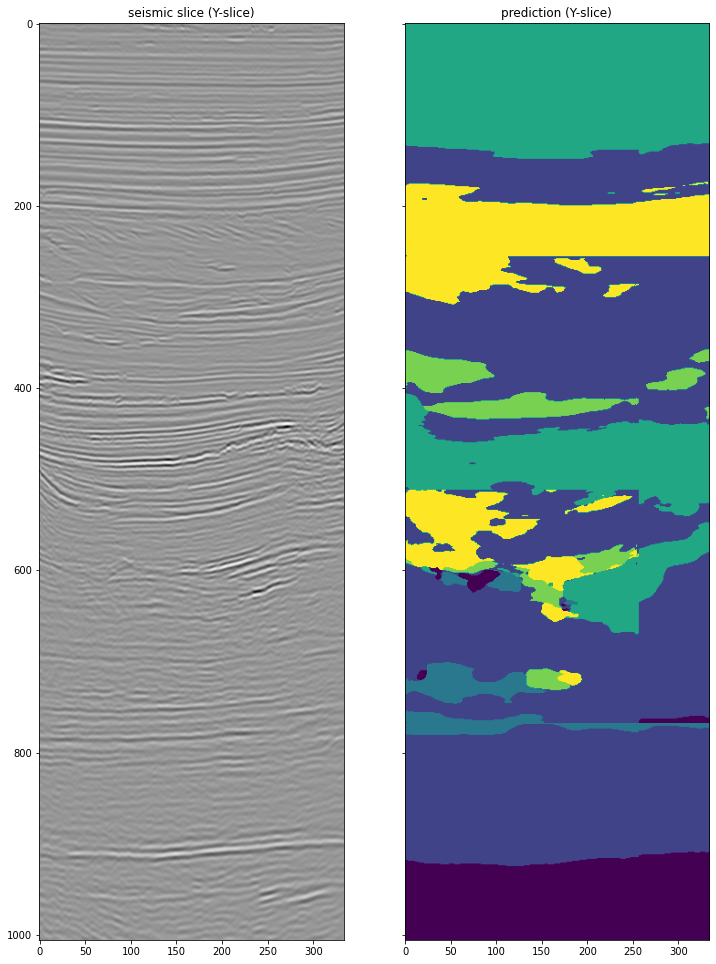

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
no_sample = 5
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,30))
ax[0].imshow(test2[:,:,no_sample], cmap='Greys')
ax[1].imshow(new_p1[:,:,no_sample], cmap='viridis')
# ax[2].imshow(newp2[:,:,no_sample], cmap='viridis')
ax[0].set_title('seismic slice (Y-slice)')
ax[1].set_title('prediction (Y-slice)')
# ax[2].set_title('correct label (Y-slice)')
plt.show()
fig.savefig('y-slice.png')

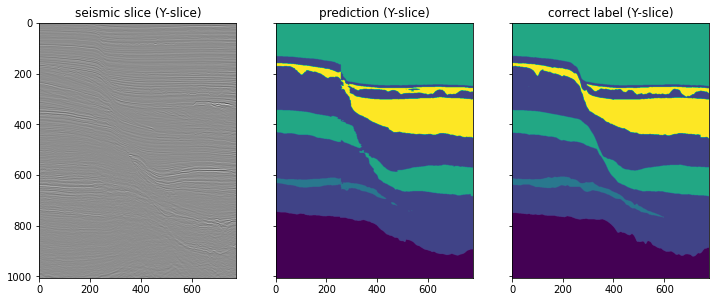

In [40]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# no_sample = 5
# fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,30))
# ax[0].imshow(test_images[:,:,no_sample], cmap='Greys')
# ax[1].imshow(new_p1[:,:,no_sample], cmap='viridis')
# ax[2].imshow(newp2[:,:,no_sample], cmap='viridis')
# ax[0].set_title('seismic slice (Y-slice)')
# ax[1].set_title('prediction (Y-slice)')
# ax[2].set_title('correct label (Y-slice)')
# plt.show()
# fig.savefig('y-slice.png')

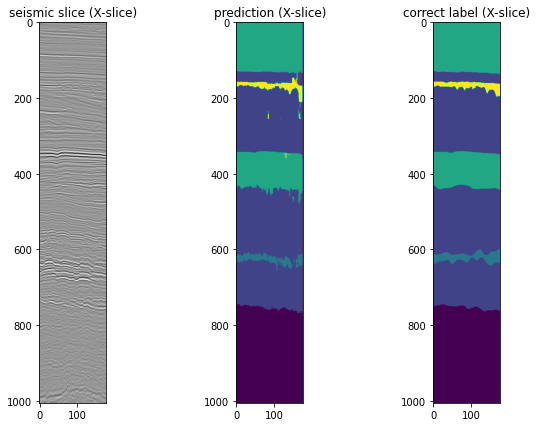

In [47]:
# no_sample = 5
# fig, ax = plt.subplots(1,3, sharey=False, figsize=(10, 7))
# ax[0].imshow(test_images[:,no_sample,:], cmap='Greys')
# ax[1].imshow(new_p1[:,no_sample,:], cmap='viridis')
# ax[2].imshow(newp2[:,no_sample,:], cmap='viridis')
# ax[0].set_title('seismic slice (X-slice)')
# ax[1].set_title('prediction (X-slice)')
# ax[2].set_title('correct label (X-slice)')
# plt.show()

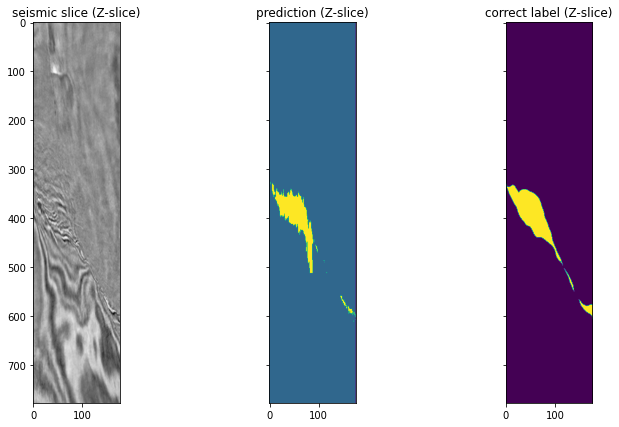

In [55]:
no_sample = 500
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12, 7))
ax[0].imshow(test_images[no_sample,:,:], cmap='Greys')
ax[1].imshow(new_p1[no_sample,:,:], cmap='viridis')
ax[2].imshow(newp2[no_sample,:,:], cmap='viridis')
ax[0].set_title('seismic slice (Z-slice)')
ax[1].set_title('prediction (Z-slice)')
ax[2].set_title('correct label (Z-slice)')
plt.show()